In [1]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls '/content/drive/Shareddrives/bangkit/Dataset_crop'

'Atopic dermatitis'   drool_rush   Impetigo     Rubeola
 cradle_cap	      hemangioma   miliaria     Varicella
'Diaper rash'	      HFMD	   pityriasis


### Total images /Category

In [4]:
print('Atopic dermatitis: {}'.format(len(os.listdir('/content/drive/Shareddrives/bangkit/Dataset_crop/Atopic dermatitis'))))
print('Diaper rash: {}'.format(len(os.listdir('/content/drive/Shareddrives/bangkit/Dataset_crop/Diaper rash'))))
print('HFMD: {}'.format(len(os.listdir('/content/drive/Shareddrives/bangkit/Dataset_crop/HFMD'))))
print('Impetigo: {}'.format(len(os.listdir('/content/drive/Shareddrives/bangkit/Dataset_crop/Impetigo'))))
print('Rubeola: {}'.format(len(os.listdir('/content/drive/Shareddrives/bangkit/Dataset_crop/Rubeola'))))
print('Varicella: {}'.format(len(os.listdir('/content/drive/Shareddrives/bangkit/Dataset_crop/Varicella'))))
print('Cradle cap: {}'.format(len(os.listdir('/content/drive/Shareddrives/bangkit/Dataset_crop/cradle_cap'))))
print('Drool Rush: {}'.format(len(os.listdir('/content/drive/Shareddrives/bangkit/Dataset_crop/drool_rush'))))
print('Hemangioma: {}'.format(len(os.listdir('/content/drive/Shareddrives/bangkit/Dataset_crop/hemangioma'))))
print('Miliraia: {}'.format(len(os.listdir('/content/drive/Shareddrives/bangkit/Dataset_crop/miliaria'))))
print('Pityriasis: {}'.format(len(os.listdir('/content/drive/Shareddrives/bangkit/Dataset_crop/pityriasis'))))

Atopic dermatitis: 108
Diaper rash: 83
HFMD: 75
Impetigo: 117
Rubeola: 66
Varicella: 70
Cradle cap: 85
Drool Rush: 65
Hemangioma: 94
Miliraia: 101
Pityriasis: 117


### Split Dataset Into Train and Val

In [5]:
!pip install split-folders tqdm

In [6]:
import splitfolders

!mkdir skin_dataset
splitfolders.ratio("//content/drive/Shareddrives/bangkit/Dataset_crop", output="skin_dataset2",seed=42, ratio=(.8,.1,.1), group_prefix=None)

Copying files: 981 files [06:01,  2.71 files/s]


Found 781 files belonging to 11 classes.


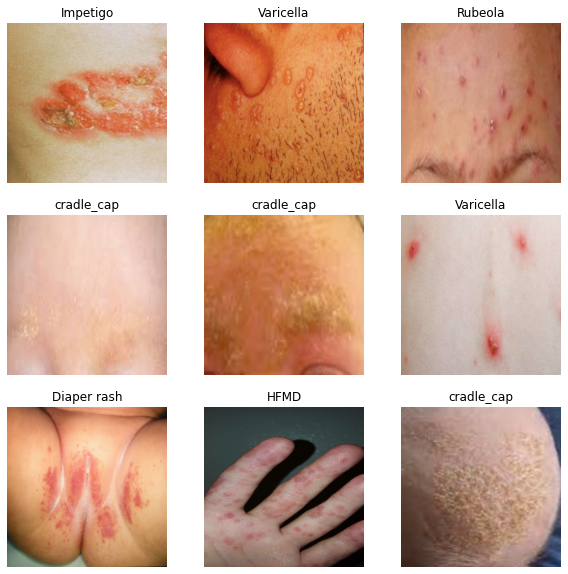

In [52]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
train_dataset = image_dataset_from_directory('/content/skin_dataset2/train',
                                             shuffle=True)

class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


### Building Model MobileNet

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [11]:
mobile = tf.keras.applications.mobilenet.MobileNet(input_tensor = tf.keras.Input(shape=(224,224,3)))

In [30]:
x = mobile.layers[-6].output
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
output = tf.keras.layers.Dense(11, activation='softmax')(x)

model = Model(inputs=mobile.input, outputs=output)
for layer in model.layers[:-13]:
# for layer in model.layers[:-23]:
  layer.trainable = False

model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0   

### Preprocessing Images

In [31]:
train_dir = '/content/skin_dataset2/train'
validation_dir = '/content/skin_dataset2/val'

train_datagen = ImageDataGenerator(rescale=1/255.0,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.4,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224,224),
                                                    batch_size=20,
                                                    class_mode = 'categorical')  


test_datagen = ImageDataGenerator(rescale=1/255.0)

validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         target_size=(224,224),
                                                         batch_size=20,
                                                         class_mode = 'categorical')

Found 781 images belonging to 11 classes.
Found 92 images belonging to 11 classes.


### Training Model

In [32]:
from tensorflow.keras.optimizers import RMSprop, Adam

model.compile(optimizer = RMSprop(lr=0.0001),
  loss='categorical_crossentropy',
  metrics=['accuracy'])

history = model.fit_generator(train_generator,
                            steps_per_epoch=20, 
                            epochs=50,
                            validation_data=validation_generator)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
20/20 [==============================] - 8s 304ms/step - loss: 2.2602 - accuracy: 0.2750 - val_loss: 2.1478 - val_accuracy: 0.3696
Epoch 2/50
20/20 [==============================] - 5s 270ms/step - loss: 2.0140 - accuracy: 0.4875 - val_loss: 1.8924 - val_accuracy: 0.4891
Epoch 3/50
20/20 [==============================] - 5s 257ms/step - loss: 1.6820 - accuracy: 0.5748 - val_loss: 1.5813 - val_accuracy: 0.5870
Epoch 4/50
20/20 [==============================] - 6s 275ms/step - loss: 1.3370 - accuracy: 0.7250 - val_loss: 1.3259 - val_accuracy: 0.6087
Epoch 5/50
20/20 [==============================] - 5s 262ms/step - loss: 1.0669 - accuracy: 0.7625 - val_loss: 1.1748 - val_accuracy: 0.6522
Epoch 6/50
20/20 [==============================] - 6s 284ms/step - loss: 0.8281 - accuracy: 0.8175 - val_loss: 1.0290 - val_accuracy: 0.7065
Epoch 7/50
20/20 [==============================] - 6s 281ms/step - loss: 0.6428 - accuracy: 0.8575 - val_loss: 0.9228 - val_accuracy: 0.7065
Epoch 

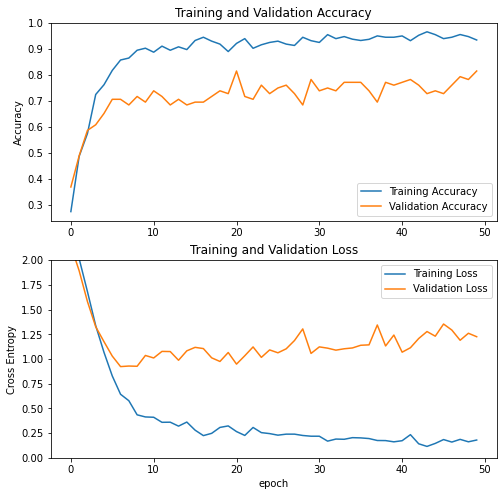

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Testing Data

In [ ]:
from google.colab import files
from keras.preprocessing import image
import numpy as np

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  images = image.load_img(path, target_size=(224,224,3))
  images = image.img_to_array(images)
  images = np.expand_dims(images, axis=0)

  classes = model.predict(images/255, batch_size=10)
  predd = np.argsort(-classes)
  predd = [j for i in predd for j in i][:3]
  for pred in predd:
    if pred == 0:
      print('Atopic dermatitis')
    elif pred == 1:
      print('Diaper rash')
    elif pred == 2:
      print('HFMD')
    elif pred == 3:
      print('Impetigo')
    elif pred == 4:
      print('Rubeola')
    elif pred == 5:
      print('Varicella')
    elif pred == 6:
      print('cradle_cap')
    elif pred == 7:
      print('drool_rush')
    elif pred == 8:
      print('hemangioma')
    elif pred == 9:
      print('miliaria')
    elif pred == 10:
      print('pityriasis')

Saving pit1.jpg to pit1.jpg
pityriasis
cradle_cap
hemangioma


In [33]:
test_dir = '/content/skin_dataset2/test'

test2_datagen = ImageDataGenerator(rescale=1/255.0)

test_generator =  test2_datagen.flow_from_directory(test_dir,
                                                         target_size=(224,224),
                                                         shuffle = False,
                                                         class_mode = 'categorical')

Found 106 images belonging to 11 classes.


In [34]:
test_labels = test_generator.classes

In [35]:
predictions = model.predict(x=test_generator, verbose=0)

In [37]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


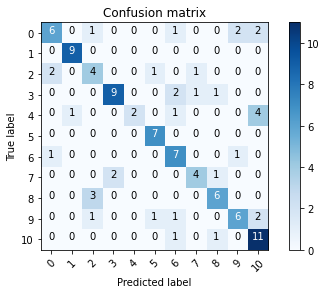

In [47]:
cm_plot_labels = ['0', '1', '2','3','4', '5', '6', '7', '8', '9', '10']
plot_confusion_matrix(cm, classes=cm_plot_labels)

### Save Model and Convert to Tensorflow Lite

In [44]:
SD_SAVED_MODEL = "skin_diseases_v1"

In [45]:
tf.saved_model.save(model, SD_SAVED_MODEL)


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: skin_diseases_v1/assets


In [46]:
!zip -r /content/skin_diseases_v1.zip /content/skin_diseases_v1

files.download('/content/skin_diseases_v1.zip')

  adding: content/skin_diseases_v1/ (stored 0%)
  adding: content/skin_diseases_v1/variables/ (stored 0%)
  adding: content/skin_diseases_v1/variables/variables.index (deflated 77%)
  adding: content/skin_diseases_v1/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/skin_diseases_v1/saved_model.pb (deflated 92%)
  adding: content/skin_diseases_v1/assets/ (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [48]:
converter = tf.lite.TFLiteConverter.from_saved_model(SD_SAVED_MODEL)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

In [49]:
tflite_model_file = 'converted_model.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

In [50]:
files.download('converted_model.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>